In [129]:
from scipy.io import loadmat
from scipy.interpolate import BSpline
from scipy.linalg import sqrtm
from scipy.optimize import fminbound
from skimage.filters import threshold_otsu
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [134]:
idle = np.array(Image.open('heat_idle.jpg').convert('L'))
load = np.array(Image.open('heat_load.jpg').convert('L'))

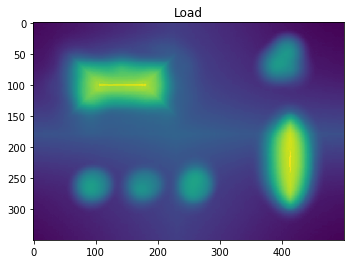

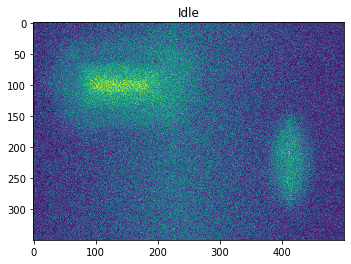

In [152]:
# Part A
plt.figure()
plt.imshow(load)
plt.title('Load')

plt.figure()
plt.imshow(idle)
plt.title('Idle')

plt.show()

In [136]:
load.shape

(350, 500)

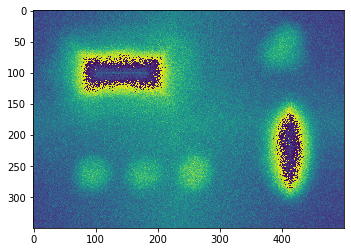

In [137]:
plt.imshow(np.clip(load+idle,0,255).astype(int))
plt.show()

In [48]:
def BSplineBasis(x: np.array, knots: np.array, degree: int) -> np.array:
    '''Return B-Spline basis. Python equivalent to bs in R or the spmak/spval combination in MATLAB.
    This function acts like the R command bs(x,knots=knots,degree=degree, intercept=False)
    Arguments:
        x: Points to evaluate spline on, sorted increasing
        knots: Spline knots, sorted increasing
        degree: Spline degree. 
    Returns:
        B: Array of shape (x.shape[0], len(knots)+degree+1). 
    Note that a spline has len(knots)+degree coefficients. However, because the intercept is missing 
    you will need to remove the last 2 columns. It's being kept this way to retain compatibility with
    both the matlab spmak way and how R's bs works.
    If K = length(knots) (includes boundary knots)
    Mapping this to R's bs: (Props to Nate Bartlett )
    bs(x,knots,degree,intercept=T)[,2:K+degree] is same as BSplineBasis(x,knots,degree)[:,:-2]
    BF = bs(x,knots,degree,intercept=F) drops the first column so BF[,1:K+degree] == BSplineBasis(x,knots,degree)[:,:-2]
    '''
    nKnots = knots.shape[0]
    lo = min(x[0], knots[0])
    hi = max(x[-1], knots[-1])
    augmented_knots = np.append(
        np.append([lo]*degree, knots), [hi]*degree)
    DOF = nKnots + degree + 1  # DOF = K+M, M = degree+1
    spline = BSpline(augmented_knots, np.eye(DOF),
                     degree, extrapolate=False)
    B = spline(x)
    return B


def thresh(x, t, tau):
    assert t in ['s', 'h']

    if t is 't':
        tmp = x.copy()
        tmp[np.abs(tmp) < tau] = 0
        return tmp
    else:
        return np.sign(x)*np.maximum(np.abs(x)-tau, 0)

def splinegcv(lam, Y, C, Z, nmiss, W):
    # % Estimate Generalized Cross-validation value

    ndim = len(np.squeeze(Y).shape)
    H = []
    dfi = np.zeros(ndim)
    for idim in range(ndim):
        # print(ndim,idim)
        L1 = C[idim].shape[0]
        # o = np.ones(L1)+lam*np.diag(C[idim])
        o = 1+lam*np.diag(C[idim])
        tmp = Z[idim]@np.diag(1/o)@Z[idim].T
        H.append(tmp)

        dfi[idim] = sum(1/(1+lam*np.diag(C[idim])))

    df = np.product(dfi)
    if ndim == 1:
        Yhat = H[0]@Y
    elif ndim == 2:
        # print(H[0].shape,H[1].shape,Y.shape)
        Yhat = H[0]@Y@H[1]
    elif ndim >= 3:
        raise NotImplementedError
        # Yhat = double(ttm(tensor(Y),H));

    if not W:
        RSS = ((Y-Yhat)**2).sum()
    else:
        diff = Y-Yhat
        RSS = (diff*W*diff).sum()

    n = len(Y)
    GCVscore = RSS/(n-nmiss)/(1-df/n)**2
    return GCVscore




def bsplineSmoothDecompauto(y, B, Ba, lam, gamma, maxIter=20, errtol=1e-6):
    def plus0(x): return np.maximum(x, 0)
    def norm(x): return np.linalg.norm(x, 2)
    sizey = y.shape
    ndim = len(y.squeeze().shape)

    if ndim == 1:
        Lbs = 2*norm(Ba[0])**2
        X = np.zeros(Ba[0].shape[1])
        a = 1
        BetaA = X.copy()
    elif ndim == 2:
        Lbs = 2*norm(Ba[0])**2*norm(Ba[1])**2
        X = np.zeros((Ba[0].shape[1], Ba[1].shape[1]))
        BetaA = X.copy()

    if len(lam) == 1:
        lam = np.ones(ndim)*lam

    SChange = 1e10
    H = []
    a = np.zeros_like(y)
    C = []
    Z = []

    for idim in range(ndim):
        Li = sqrtm(B[idim].T@B[idim])
        Li = Li + 1e-8*np.eye(*Li.shape)
        Di = np.diff(np.eye(B[idim].shape[1]), 1, axis=0)
        tmp = np.linalg.pinv(Li.T)@(Di.T@Di)@np.linalg.pinv(Li)
        Ui, ctmp, _ = np.linalg.svd(tmp)
        C.append(np.diag(ctmp))
        Z.append(B[idim]@np.linalg.pinv(Li.T)@Ui)

    iIter = 0
    t = 1

    while SChange > errtol and iIter < maxIter:
        iIter += 1
        Sold = a
        BetaSold = BetaA
        told = t
        def gcv(x): return splinegcv(x, y, C, Z, 0, [])

        if len(lam) == 0 and iIter == 1:
            lam = fminbound(gcv, 1e-2, 1e3)
            lam = lam*np.ones(ndim)

        # % %
        H = []
        for idim in range(ndim):
            L1 = C[idim].shape[0]
            o = np.ones(L1)+lam[idim]*np.diag(C[idim])
            tmp = Z[idim]@np.diag(1/o)@Z[idim].T
            H.append(tmp)
        if ndim == 1:
            yhat = H[0]@(y-a)
            BetaSe = X + 2/Lbs*Ba[0].T@(y - Ba[0]@X - yhat)
        elif ndim == 2:
            yhat = H[0]@(y-a)@H[1]
            BetaSe = X + 2/Lbs*Ba[0].T@(y - Ba[0]@X@Ba[1].T - yhat)@Ba[1]

        maxYe = np.abs(BetaSe).max()

        # %
        if not gamma and iIter % 3 == 1:
            gamma = threshold_otsu(np.abs(BetaSe)/maxYe)*maxYe*Lbs

        # change 'h' to 's' for softthresholding
        BetaA = thresh(BetaSe, 'h', gamma/Lbs)
        if ndim == 1:
            a = Ba[0] @BetaA
        elif ndim == 2:
            a = Ba[0] @BetaA@ Ba[1].T
        t = (1+(1+4*told**2)**0.5)/2

        if iIter == 1:
            X = BetaA
        else:
            X = BetaA+(told-1)/t*(BetaA-BetaSold)

        SChange = a-Sold
        SChange = (SChange**2).sum()

    return yhat, a




In [157]:

def decomp(A,Y, sigma=.05, delta=.2, knots=6, snk=4):
    
    Y = Y + delta*A 

    kx = knots
    ky = knots
    nx, ny = Y.shape
    B1 = BSplineBasis(np.arange(nx), np.linspace(0, nx-1, kx), 2)[:, :-2]
    B2 = BSplineBasis(np.arange(ny), np.linspace(0, ny-1, ky), 2)[:, :-2]
    snk = 4
    skx = int(np.round(nx/snk))
    sky = int(np.round(ny/snk))
    Bs1 = BSplineBasis(np.arange(nx), np.linspace(0, nx-1, skx), 1)[:, :-2]
    Bs2 = BSplineBasis(np.arange(ny), np.linspace(0, ny-1, sky), 1)[:, :-2]

    y = Y
    B = [B1, B2]
    Ba = [Bs1, Bs2]
    lam = []
    gamma = []
    maxIter = 20
    errtol = 1e-6

    yhat, a = bsplineSmoothDecompauto(Y, B, Ba, [], [])
    return Y, yhat,a

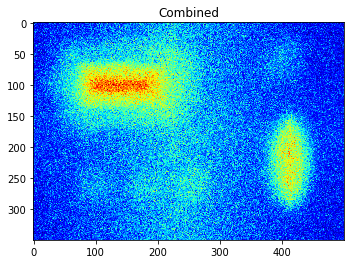

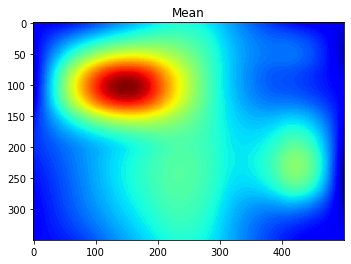

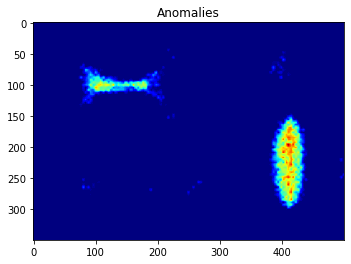

In [151]:
# Part B
Y,yhat,a = decomp(load,idle)
plt.figure()
plt.imshow(np.clip(Y, 0, 255).astype(int),cmap='jet')
plt.title('Combined')


plt.figure()
plt.imshow(np.clip(yhat, 0, 255).astype(int),cmap='jet')
plt.title('Mean')
plt.show()

plt.figure()
plt.imshow(np.clip(a, 0, 255).astype(int),cmap='jet')
plt.title('Anomalies')
plt.show()

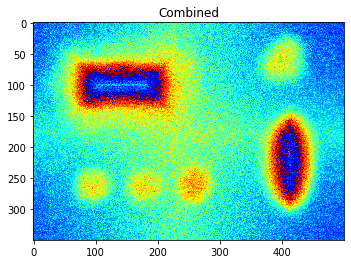

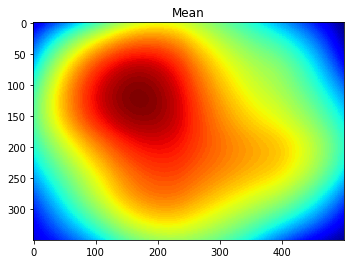

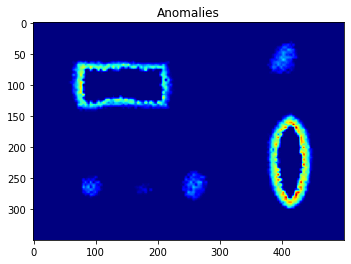

In [168]:
# Part C
Y,yhat,a = decomp(load,idle, delta=1, knots=5)
plt.figure()
plt.imshow(np.clip(Y, 0, 255).astype(int),cmap='jet')
plt.title('Combined')


plt.figure()
plt.imshow(np.clip(yhat, 0, 255).astype(int),cmap='jet')
plt.title('Mean')
plt.show()

plt.figure()
plt.imshow(np.clip(a, 0, 255).astype(int),cmap='jet')
plt.title('Anomalies')
plt.show()

I basically just played around with the parameters until I was happy with the output.  I chose the above output because we want to detect where the heat was spreading and I felt like the "anomaly" image does that well.  Two areas are ringed showing that heat is spreading from those two areas that were warm under the idle condition, but spreading under outward under load.